#### Quantum Computing: from Fundamentals to Applications - Summer School 2025
# Hands-on with Qiskit: Variational quantum eigensolver




## VQE in a nutshell

[Variational quantum algorithms](https://arxiv.org/abs/2012.09265) are a promising class of hybrid quantum-classical algorithms for observing quantum computing utility on noisy near-term devices. Variational algorithms are characterized by the use of a classical optimization algorithm to iteratively update a parameterized trial solution, or "ansatz". Chief among these methods is the Variational Quantum Eigensolver (VQE) that aims to solve for the ground state of a given Hamiltonian, usually represented as a linear combination of Pauli terms. VQE is based on the Rayleigh-Ritz variational principle, which states that the ground state energy $E_0$ is always less than or equal to the expectation value of the Hamiltonian $\hat{H}$ when evaluated on any trial state $|\Psi\rangle$:

$$
E_0 \leq \frac{\langle \Psi | \hat{H} | \Psi \rangle}{\langle \Psi | \Psi \rangle}.
$$

When the trial state $|\Psi\rangle$ coincides with the actual ground state $|\Psi_0\rangle$, then the inequality becomes an equality:

$$
E_0 = \frac{\langle \Psi_0 | \hat{H} | \Psi_0 \rangle}{\langle \Psi_0 | \Psi_0 \rangle}.
$$

We can leverage this variational principle by generating a family of states that aims to include the ground state. Then, we can start optimizating the parameters $\vec{\theta}$ to make our trial state as close to the ground state as possible

Now that we have the variational principle, we can use it by building a family of quantum states $|\Psi (\vec{\theta})\rangle$ that aims to include the ground state. These states are generated by a parameterized circuit, and the idea is to tweak the parameters $\vec{\theta}$ so that the trial state $|\Psi(\vec{\theta})\rangle$ gets as close as possible to the actual ground state $|\Psi_0 \rangle$.

Hence, the workflow of VQE is as follows:

1. Hamiltonian Encoding: 
   Represent the system's Hamiltonian $H$ as a weighted sum of Pauli operators:

   $$
   H = \sum_j c_j \hat{P}_j,
   $$

   where $\hat{P}_j$ are tensor products of Pauli matrices and $c_j \in \mathbb{R}$.

2. Ansatz Selection:
   Choose a parameterized quantum circuit $U(\vec{\theta})$ to generate a family of trial states:

   $$
   |\Psi(\vec{\theta})\rangle = U(\vec{\theta}) |0\rangle.
   $$

3. Qiskit Runtime estimator:
   Estimate the expectation value of the Hamiltonian:

   $$
   E(\vec{\theta}) = \sum_j c_j \langle \Psi(\vec{\theta}) | \hat{P}_j | \Psi(\vec{\theta}) \rangle.
   $$

4. Classical Optimization: 
   Use a classical optimizer to update $\vec{\theta}$ to minimize $E(\vec{\theta})$ and accomplish $|\Psi(\vec{\theta})\rangle \approx |\Psi_0 \rangle$.

VQE is suitable for current devices due to its shallow circuit depth and robustness to noise. The effectiveness of VQE depends on the expressivity of the ansatz and the efficiency of the classical optimization routine.

In this notebook, we will dig into how you can use VQE to estimate the ground state of the Hydrogen molecule $H_2$!

## Requirements

Before starting this tutorial, ensure that you have the following installed:

*   Qiskit SDK 2.0 or later, with visualization support (`pip install 'qiskit[visualization]'`)
*   Qiskit Runtime 0.40 or later(`pip install qiskit-ibm-runtime`)



## Setup



In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize

from qiskit.circuit.library import efficient_su2
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import (
    Session,
    EstimatorV2 as Estimator,
    SamplerV2 as Sampler,
)
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

## Step 1: Mapping classical inputs to a quantum problem

In this demo, we will explore the electronic structure of the hydrogen molecule ($H_2$) using a 4-qubit Hamiltonian derived from quantum chemistry principles. 

Starting from the fermionic representation of the molecular Hamiltonian in a minimal basis set, we apply the Jordan-Wigner transformation to map fermionic creation and annihilation operators into qubit operators. Each fermionic term, such as $a^\dagger_i a_j$ or $a^\dagger_i a^\dagger_j a_k a_l$, is translated into a combination of Pauli strings involving $X$, $Y$, and $Z$ operators acting on specific qubits. For a detailed explanation of this procedure, we refer you to [Seeley et. al 2012](https://arxiv.org/abs/1208.5986).

This results in a qubit Hamiltonian composed of Pauli strings involving the identity, Z, and multi-qubit XX and YY interactions that will look like this:

\begin{align*}
H =\ & c_1\, I I I I + c_2\, Z I I I + c_3\, I Z I I + c_4\, I I Z I + c_5\, I I I Z \\
& + c_6\, Z Z I I + c_7\, Z I Z I + c_8\, I Z Z I + c_9\, Z I I Z + c_{10}\, I Z I Z \\
& + c_{11}\, I I Z Z + c_{12}\, Y Y X X + c_{13}\, X Y Y X + c_{14}\, Y X X Y + c_{15}\, X X Y Y,
\end{align*}

where the coefficients $c_i$ depend on the interatomic distance between the hydrogen nuclei.

This model captures essential electron correlation effects and provides an interesting testbed for VQE, allowing us to approximate the ground state energy of ($H_2$) using a quantum algorithm.

We can now define the list of Pauli terms with their respectives coefficients to build the problem Hamiltonian.

In [2]:
pauli_terms_jw= [
    ("IIII", -0.81261),
    ("IIIZ", 0.171201),
    ("IIZI", 0.171201),
    ("IZII", -0.2227965),
    ("ZIII", -0.2227965),
    ("IIZZ", 0.16862325),
    ("IZIZ", 0.12054625),
    ("IZZI", 0.165868),
    ("ZIIZ", 0.165868),
    ("ZIZI", 0.12054625),
    ("ZZII", 0.17434925),
    ("XXYY", -0.04532175),
    ("XYYX", 0.04532175),
    ("YXXY", 0.04532175),
    ("YYXX", -0.04532175)
]
hamiltonian = SparsePauliOp.from_list(pauli_terms_jw)
n=hamiltonian.num_qubits
# We take a look at the hamiltonian
hamiltonian

SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IZII', 'ZIII', 'IIZZ', 'IZIZ', 'IZZI', 'ZIIZ', 'ZIZI', 'ZZII', 'XXYY', 'XYYX', 'YXXY', 'YYXX'],
              coeffs=[-0.81261   +0.j,  0.171201  +0.j,  0.171201  +0.j, -0.2227965 +0.j,
 -0.2227965 +0.j,  0.16862325+0.j,  0.12054625+0.j,  0.165868  +0.j,
  0.165868  +0.j,  0.12054625+0.j,  0.17434925+0.j, -0.04532175+0.j,
  0.04532175+0.j,  0.04532175+0.j, -0.04532175+0.j])

Now we need to choose an ansatz that will generate a family of states $|\Psi(\vec{\theta})\rangle$ containing the ground state of the Hamiltonian.

To that aim, our choice of ansatz is the `efficient_su2` which by default applies linear entanglement between qubits—making it ideal for quantum hardware with limited connectivity. For more information, check out the documentation for [EfficientSU2](https://quantum.cloud.ibm.com/docs/en/api/qiskit/qiskit.circuit.library.EfficientSU2).

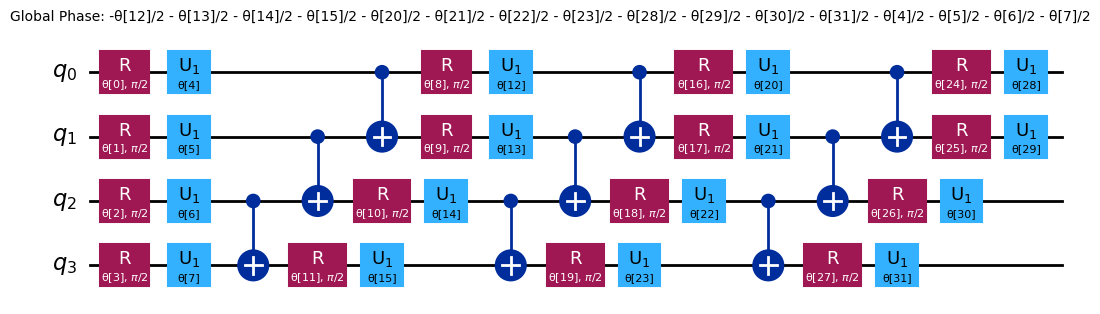

In [3]:
ansatz = efficient_su2(hamiltonian.num_qubits)
ansatz.decompose().draw("mpl")

We define a quantum circuit that includes measurements, since we will need measurements to use the Qiskit primitive `Sampler`.

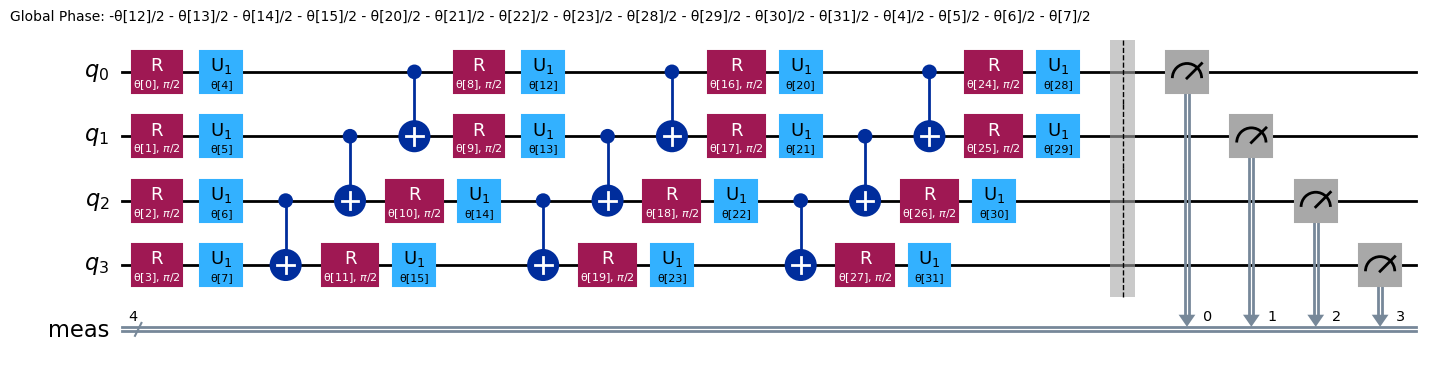

In [5]:
ansatz_measurements=ansatz.copy()
ansatz_measurements.measure_all()
ansatz_measurements.decompose().draw("mpl")

From the previous figure we see that our ansatz circuit is defined by a vector of parameters, $\theta_{i}$, with the total number given by:



In [6]:
num_params = ansatz.num_parameters
num_params

32

## Step 2: Optimize problem for quantum hardware execution

Let's define the backend we want to use


In [6]:
service = QiskitRuntimeService()
backend = service.least_busy(
   operational=True, simulator=False
)
print(f"We are using {backend.name}")

We are using ibm_brisbane


Now, to avoid consuming valuable resources by running this demo on actual hardware, we will use a noisy simulator that mimics the noise of the real device. However, one can skip the next cell and execute everything on hardware.

In [ ]:
# Run this cell if you want a simulator version of the backend
seed=42
backend = AerSimulator.from_backend(backend, seed_simulator=seed)

Also, one can use a noise-free simulator that still has the same connectivity and number of qubits than the real hardware:

In [8]:
#backend.set_options(noise_model=False)

*Note: The optimizer will train considerably faster when we consider a noise-free simulation*

### ISA circuit



The next step is to transpile our quantum circuit to match the Instruction Set Architecture (ISA) of the selected backend. Transpilation ensures that the circuit respects the device's native number of qubits, gate set, and connectivity, making it executable on real quantum hardware.

This can be easily done with a preset pass manager from `qiskit.transpiler` and selecting a suitable value for its `optimization_level` parameter.

The lowest optimization level does the minimum needed to get the circuit running on the device; it maps the circuit qubits to the device qubits and adds swap gates to allow all two-qubit operations. The highest optimization level is much more complex and uses lots of tricks to reduce the overall gate count. Since multi-qubit gates have high error rates and qubits decohere over time, the shorter circuits should give better results. However, keep in mind there's always a trade-off: applying more rigorous optimization means higher computational cost.


In [9]:
target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)
ansatz_isa = pm.run(ansatz)
ansatz_isa_measurements=pm.run(ansatz_measurements)

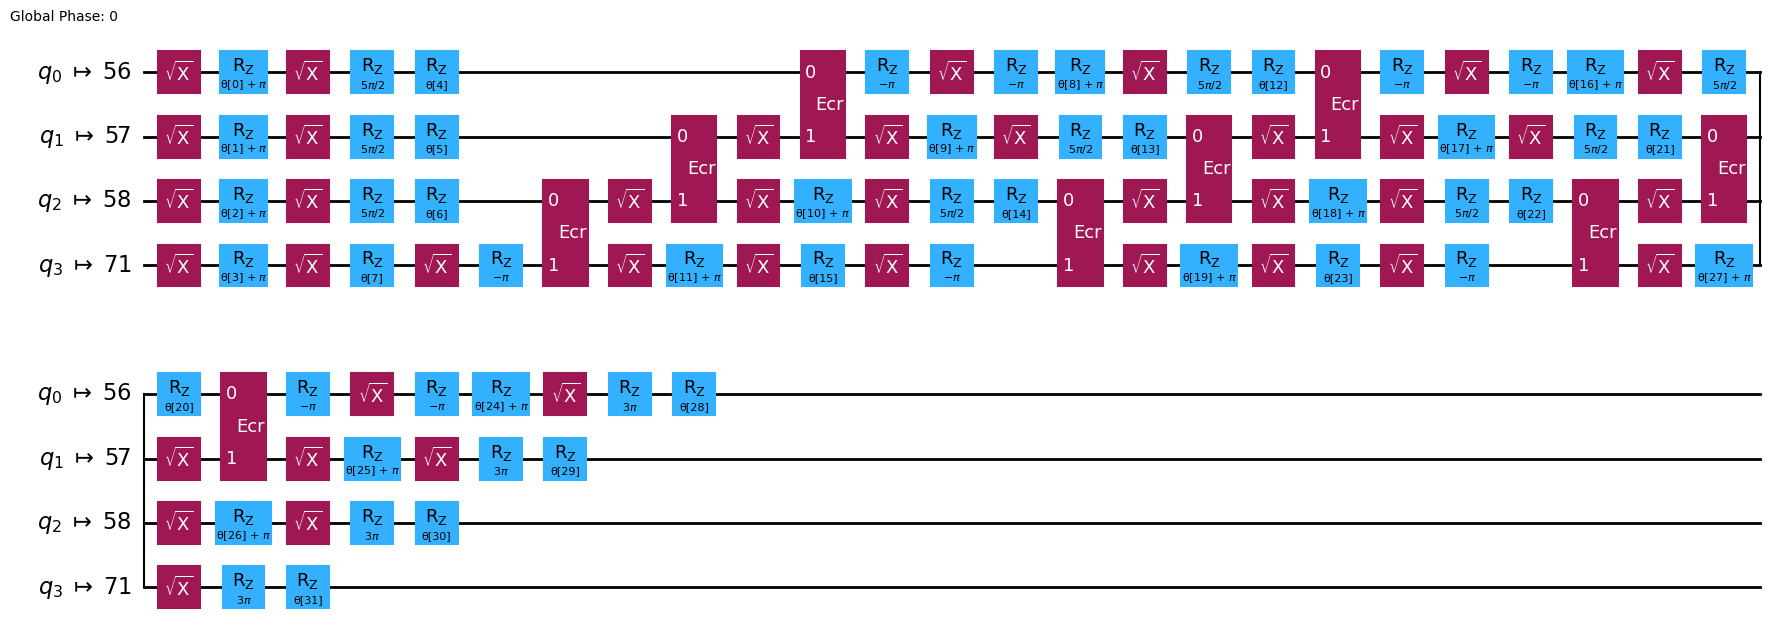

In [10]:
ansatz_isa.draw(output="mpl", idle_wires=False, style="iqp")

### ISA observable



Transform the Hamiltonian to make it backend-compatible before running jobs with [`Runtime Estimator V2`](/docs/api/qiskit-ibm-runtime/estimator-v2#run). Perform the transformation by using the `apply_layout` method of `SparsePauliOp` object.



In [11]:
hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)

## Step 3: Execute using Qiskit primitives

Like many classical optimization problems, the solution to a VQE problem can be formulated as a minimization of a scalar cost function.  By definition, VQE searches for the ground state solution to a Hamiltonian by optimizing the ansatz circuit parameters to minimize the expectation value (energy) of the Hamiltonian.  

With the Qiskit Runtime `Estimator`directly taking a Hamiltonian and parameterized ansatz, and returning the necessary energy, the cost function for a VQE instance is quite simple.

The `run()` method of [Qiskit Runtime `EstimatorV2`](https://quantum.cloud.ibm.com/docs/en/api/qiskit-ibm-runtime/estimator-v2) takes an iterable of `primitive unified blocs (PUBs)`. Each PUB is an iterable in the format of a tuple`(circuit, observables, parameter_values: optional, precision: optional)`. It also takes `precision` (float | `None`), which is the target precision for expectation value estimates of each run Estimator Pub that does not specify its own precision.



Note that, in addition to the array of optimization parameters that must be the first argument, we use additional arguments to pass the terms needed in the cost function. We also access a global variable called `cost_history_dict` within this function. This dictionary stores the current vector at each iteration, for example in case you need to restart the routine due to failure, and also returns the current iteration number and average time per iteration.


In [14]:
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]
    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    print(
        f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy:.6f}]"
    )

    return energy

We can now use a classical optimizer of our choice to minimize the cost function. Here, we use the [COBYLA routine from SciPy through the `minimize` function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html). Note that when running on real quantum hardware, the choice of optimizer is important, as not all optimizers handle noisy cost function landscapes equally well.

To begin the routine, specify a random initial set of parameters:



In [15]:
x0 = np.zeros(num_params)

Because we are sending a large number of jobs that we would like to execute iteratively, we use a [`Session`](https://docs.quantum-computing.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.Session) to execute all the generated circuits in one block.  Here `args` is the standard SciPy way to supply the additional parameters needed by the cost function.



In [16]:
with Session(backend=backend) as session:
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 10000

    res = minimize(
        cost_func,
        x0,
        args=(ansatz_isa, hamiltonian_isa, estimator),
        method="COBYLA",
        options={"maxiter": 150, "rhobeg": 1, "catol": 1e-2, "tol": 0.001}
    )

Iters. done: 1 [Current cost: -0.097107]
Iters. done: 2 [Current cost: -0.049745]
Iters. done: 3 [Current cost: -0.166076]
Iters. done: 4 [Current cost: -0.234438]
Iters. done: 5 [Current cost: -0.334434]
Iters. done: 6 [Current cost: -0.334425]
Iters. done: 7 [Current cost: -0.334180]
Iters. done: 8 [Current cost: -0.336056]
Iters. done: 9 [Current cost: -0.334760]
Iters. done: 10 [Current cost: -0.507552]
Iters. done: 11 [Current cost: -0.660756]
Iters. done: 12 [Current cost: -0.626412]
Iters. done: 13 [Current cost: -0.775093]
Iters. done: 14 [Current cost: -0.749821]
Iters. done: 15 [Current cost: -0.774095]
Iters. done: 16 [Current cost: -0.775201]
Iters. done: 17 [Current cost: -0.774476]
Iters. done: 18 [Current cost: -0.861141]
Iters. done: 19 [Current cost: -0.662144]
Iters. done: 20 [Current cost: -0.827067]
Iters. done: 21 [Current cost: -0.767028]
Iters. done: 22 [Current cost: -0.835888]
Iters. done: 23 [Current cost: -0.860398]
Iters. done: 24 [Current cost: -0.870822]
I

At the end of the optimization stage we have a result in the standard SciPy `OptimizeResult` format.  From this we see that it took `nfev` number of cost function evaluations to obtain the solution vector of parameter angles (`x`) that, when plugged into the ansatz circuit, yield the approximate ground state solution we were looking for. Additionally, we can take a look at the training history in `cost_history_dict`.


 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -1.6994831982499998
       x: [-5.150e-02  1.359e+00 ...  1.507e+00  1.699e-01]
    nfev: 150
   maxcv: 0.0


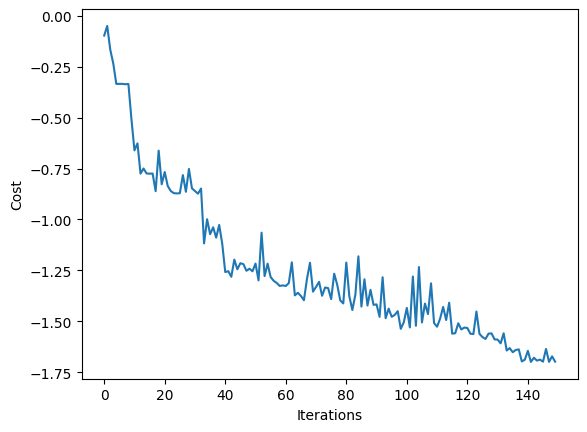

In [17]:
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()
print(res)

## Step 4: Post-process and return result in desired classical format



Once the parameters of the ansatz have been optimized, we can use the `Sampler` to see which ground state it generates.

In [18]:
SHOTS = 10000
def sample_vqe(opt_params, circuit, backend):

    # Submit the circuit to Sampler
    options = {"simulator": {"seed_simulator": seed}}
    sampler = Sampler(mode=backend, options=options)
    job = sampler.run([(circuit, opt_params)], shots=SHOTS)
    results_sampler = job.result()
    counts_list = results_sampler[0].data.meas.get_counts()
    display(plot_histogram(counts_list, title=f"Ground state of $H_2$"))
    return counts_list

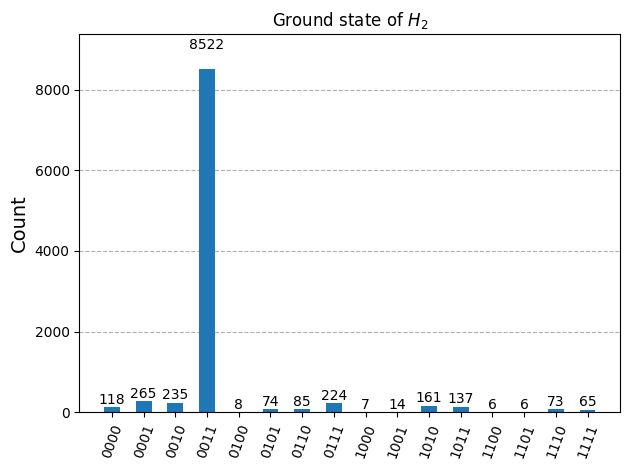

In [19]:
counts_list_vqe = sample_vqe(res.x, ansatz_isa_measurements, backend)

# Comparison with analytical solution

We can analytically diagonalize the Hamiltonian of the $H_2$ molecule and compare the ground state energy obtained via VQE with the exact solution. This serves as a useful benchmark to evaluate the accuracy of our quantum algorithm.

Note that this isn't always the case, as for larger, more complex molecules getting exact solutions is either not straightforward or not viable.

Let's begin by diagonalizing the Hamiltonian:

In [20]:
eigenvalues, eigenvectors = np.linalg.eig(hamiltonian)
ground_energy = min(eigenvalues).real
num_solutions = eigenvalues.real.tolist().count(ground_energy)
index_solutions = np.where(eigenvalues.real == ground_energy)[0].tolist()
print(f"The ground energy of the Hamiltonian is {ground_energy}")
print(f"The number of solutions of the problem is {num_solutions}")

The ground energy of the Hamiltonian is -1.851045678444864
The number of solutions of the problem is 1


Now, we compare the analytical solution with the VQE results:

In [22]:
# Convert decimal indices to binary strings
states_solutions = [format(i, f'0{n}b') for i in index_solutions]
# Get top VQE states by count
vqe_ground_states = sorted(counts_list_vqe, key=counts_list_vqe.get, reverse=True)[:num_solutions]

print(f"Analytical solution for H\u2082: {states_solutions}")
print(f"VQE ground state solution for H\u2082: {vqe_ground_states}")


Analytical solution for H₂: ['0011']
VQE ground state solution for H₂: ['0011']


# Next Steps

Well done! You have successfully used VQE to estimate the ground state energy of the hydrogen molecule $H_2$. This demonstrates how quantum algorithms can be applied to solve problems in quantum chemistry. 


Explore the course [https://quantum.cloud.ibm.com/learning/en/courses/quantum-chem-with-vqe]


As a next step, you could run the same algorithm on actual quantum hardware to explore how the actual noise of the hardware affects the results. You can also extend this approach to more complex molecules by using [PySCF](https://pyscf.org/) for electronic structure calculations and take a look at the course below to lean how to build the problem Hamiltonians.




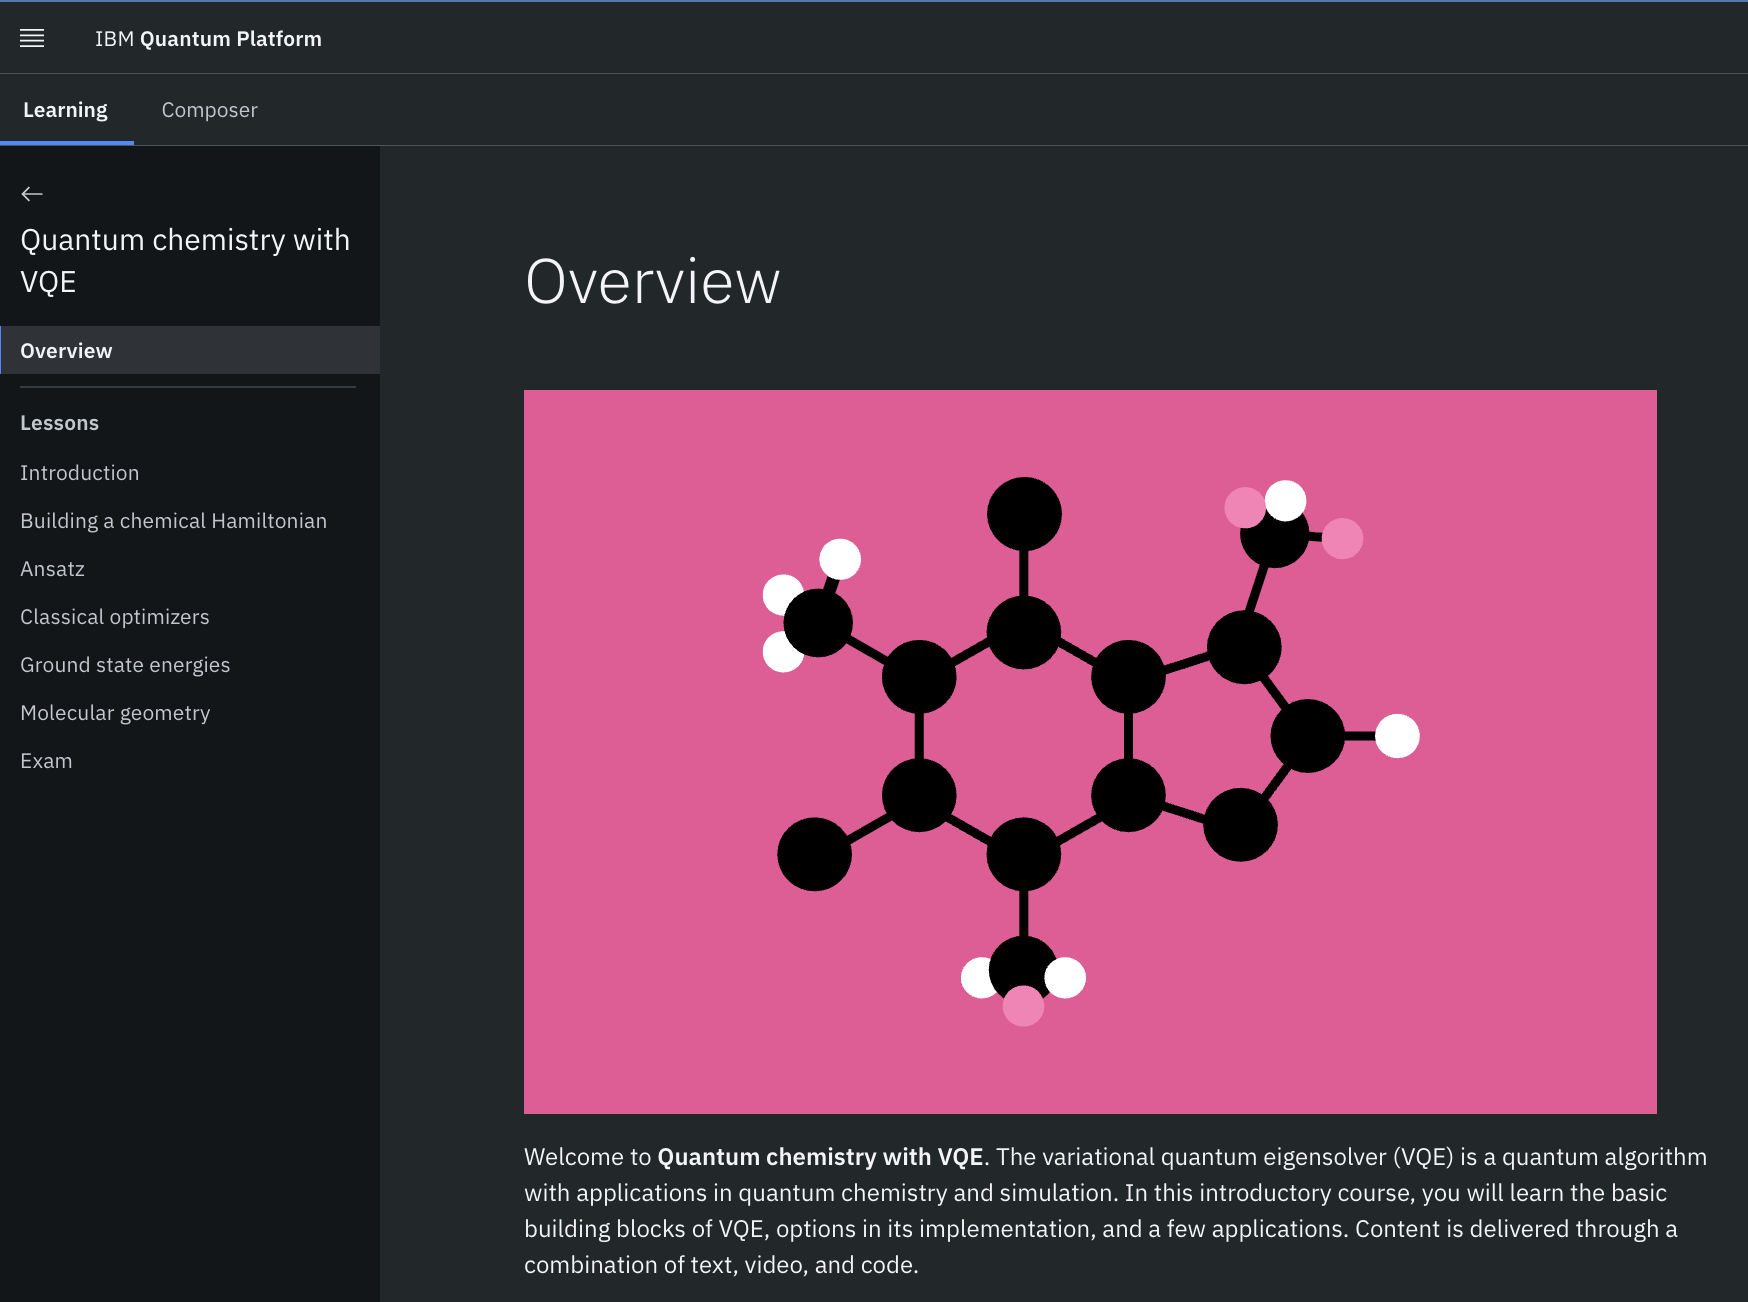

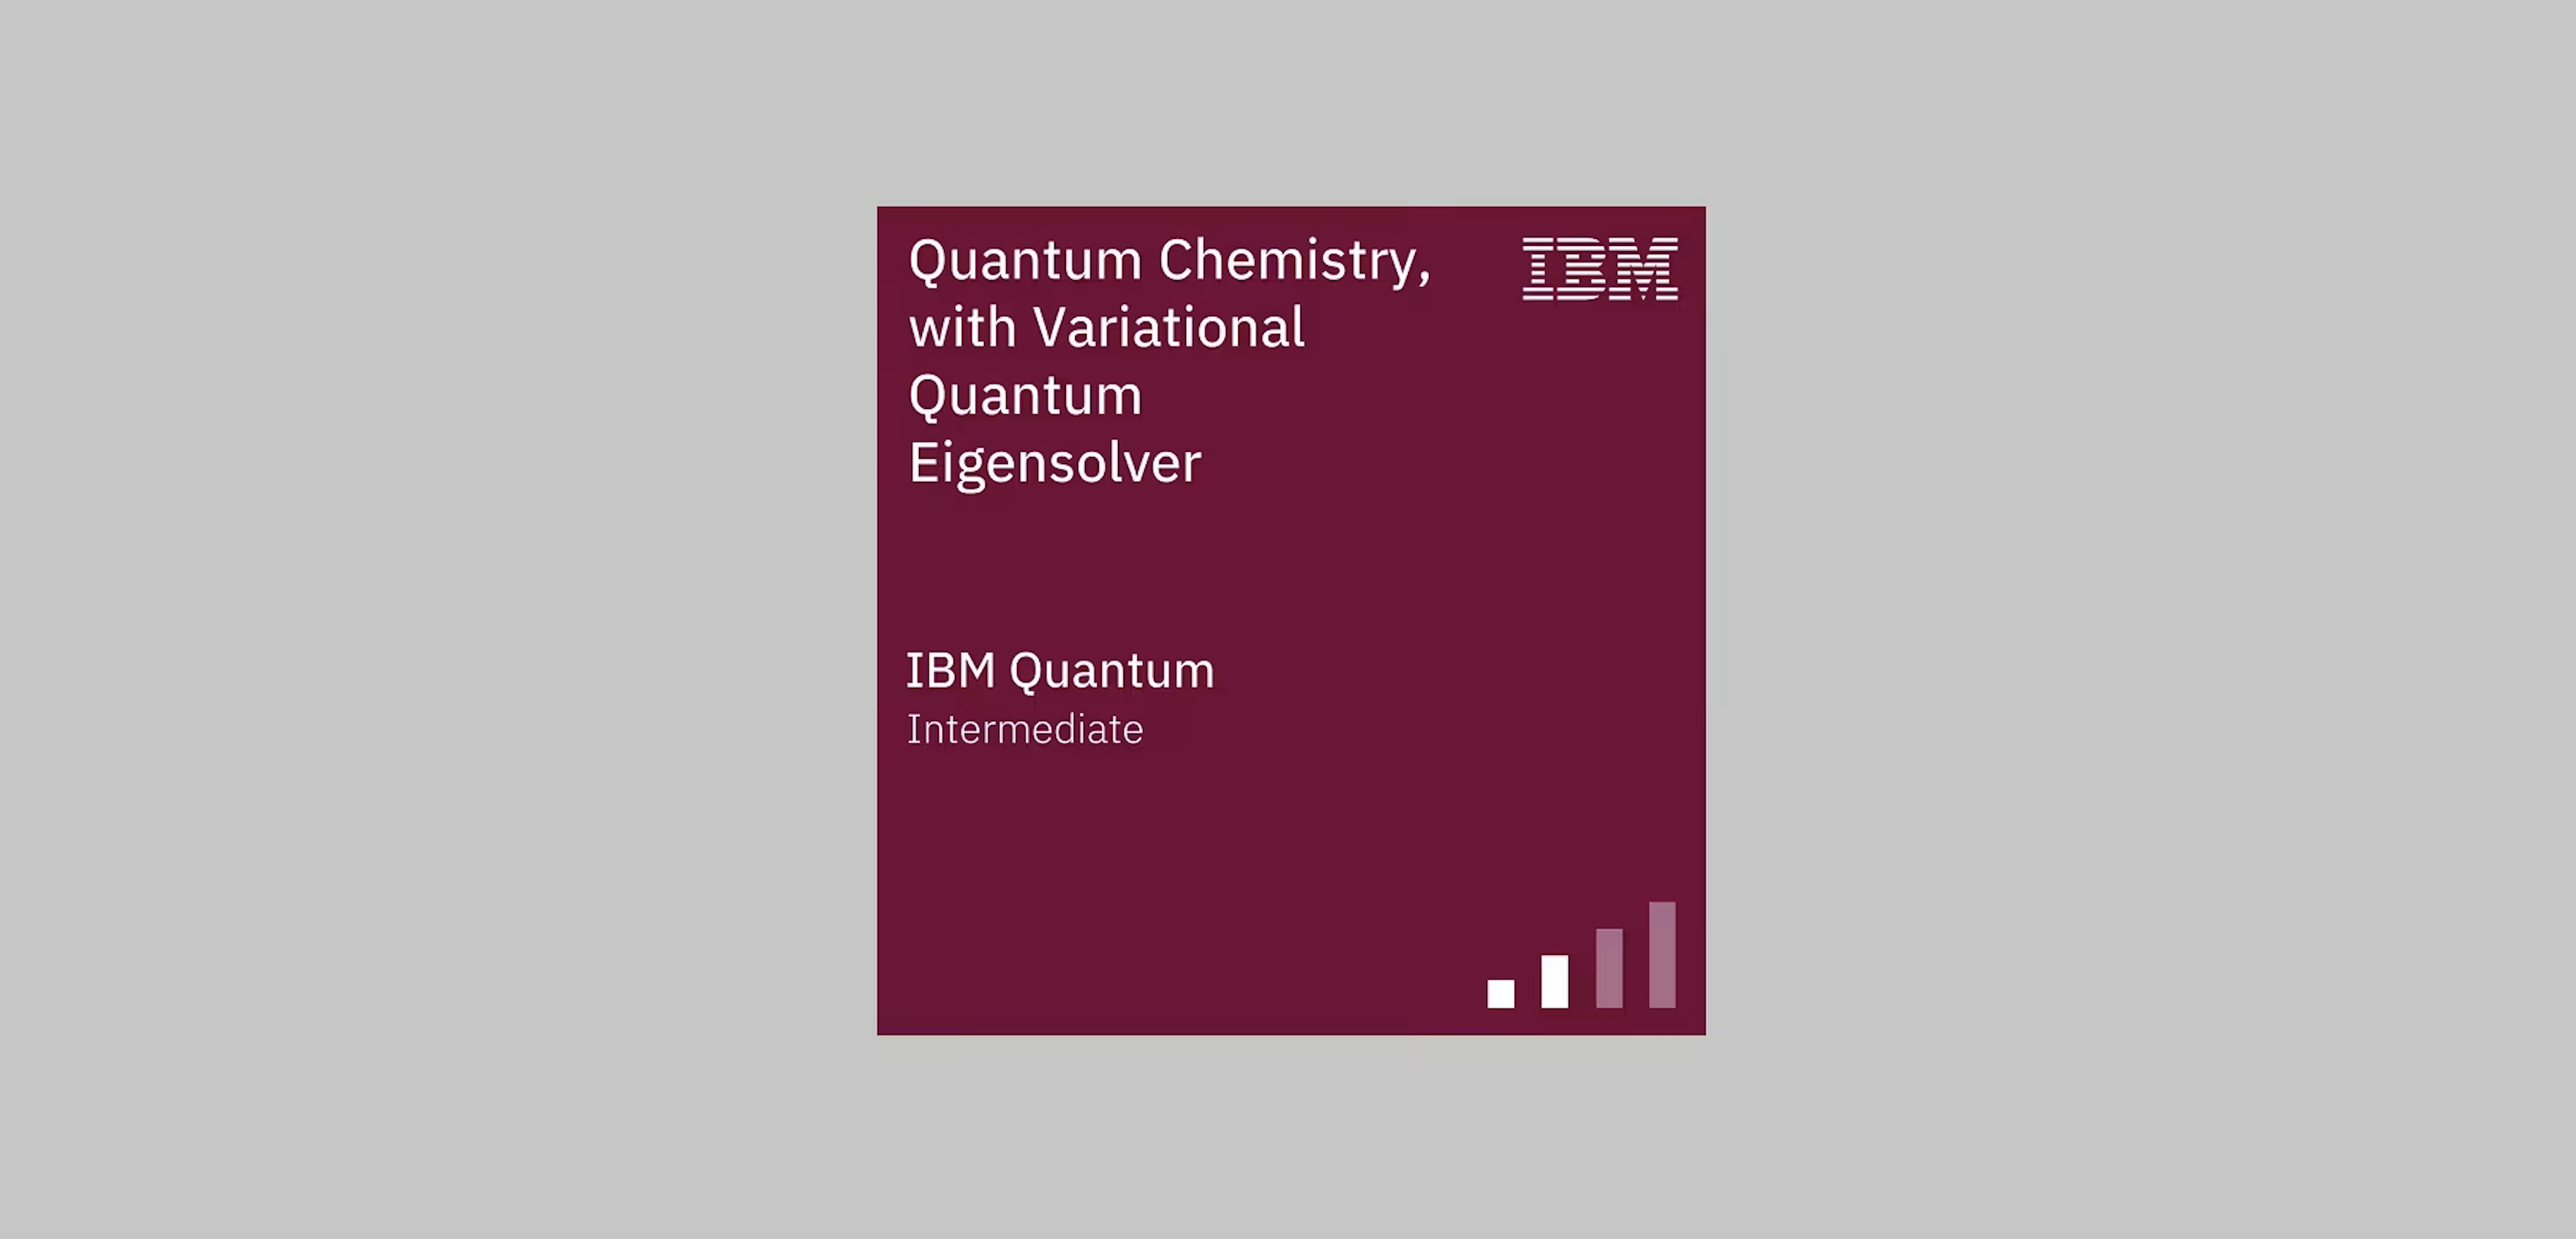

For a deeper dive and understanding of VQE through the lens of quantum chemistry, check out this short course on IBM Quantum Learning: []()

You can earn an official Credly badge for completing the course! 

*Note from presenter: if you end up earning this badge I (Radha Pyari Sandhir) would love to know! Please contact me at radha.pyari@ibm.com*